In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../DataOut/bus_trip_all_points_moddedDF.csv')
# import bus trips
bus_trips = pd.read_csv("../DataOut/bus_trips.csv")

# Pre Process

selecting the data before the last available month to create these features, because we are going to use the last month for testing our furure models

In [2]:
# print raws when date is afeter 2022-10-31
data=data[data['date'] > '2022-10-01']
data

,id,deviceid,devicetime,latitude,longitude,speed,date,time,geometry,bus_stop,trip_id,direction
84987,1457239669,116,2022-10-02 09:10:19,7.292927,80.635065,6.47948,2022-10-02,09:10:19,POINT (184690.28640732626 232304.53045894875),BT01,847.0,1
84988,1457239672,116,2022-10-02 09:10:34,7.293085,80.635912,16.19870,2022-10-02,09:10:34,POINT (184783.76917955113 232322.01850791794),NaN,847.0,1
84989,1457239673,116,2022-10-02 09:10:49,7.293032,80.637115,12.41900,2022-10-02,09:10:49,POINT (184916.64100951015 232316.07360530586),NaN,847.0,1
84990,1457239674,116,2022-10-02 09:11:04,7.292940,80.637748,7.01944,2022-10-02,09:11:04,POINT (184986.56392305848 232305.92345087207),NaN,847.0,1
84991,1457239675,116,2022-10-02 09:11:19,7.292278,80.637653,9.17927,2022-10-02,09:11:19,POINT (184976.0527496817 232232.754163777),NaN,847.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3515464,1542914504,1377,2022-10-30 17:48:52,7.290398,80.639213,11.87910,2022-10-30,17:48:52,POINT (185148.23966477055 232024.80834314524),213,14367.0,2
3515465,1542914505,1377,2022-10-30 17:49:07,7.290688,80.638332,16.19870,2022-10-30,17:49:07,POINT (185050.89552919852 232056.90591013635),NaN,14367.0,2
3515466,1542914506,1377,2022-10-30 17:49:22,7.291190,80.637320,12.41900,2022-10-30,17:49:22,POINT (184939.20444824686 232112.41824199155),NaN,14367.0,2
3515467,1542914507,1377,2022-10-30 17:49:36,7.291315,80.635967,29.15770,2022-10-30,17:49:36,POINT (184789.78315181087 232126.27469226017),NaN,14367.0,2


In [7]:
# print a list of unique trip ids
trip_ids = data['trip_id'].unique()
# convert the list values to int
trip_ids = [int(x) for x in trip_ids]
print('unique trip ids: {}'.format(trip_ids))
# print length
print('length of unique trip ids: {}'.format(len(trip_ids)))

unique trip ids: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 378, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420, 422, 424

## Detect and remove Anomaly Trips

In [10]:

from sklearn.metrics.pairwise import haversine_distances
from math import radians

# Define a function to calculate Haversine distance between two points
def haversine_distance(coord1, coord2):
    coord1 = [radians(x) for x in coord1]
    coord2 = [radians(x) for x in coord2]
    dist = haversine_distances([coord1, coord2])
    return dist[0][1] * 6371000.0  # Multiply by Earth radius to get distance in meters

# Define the anomaly detection function
def detect_anomalies(data, trip_id_column, longitude_column, latitude_column, reference_data, reference_trip_id, threshold_distance_meters=200):
    reference_locations = reference_data[reference_data[trip_id_column] == reference_trip_id]
    reference_locations = reference_locations[[latitude_column, longitude_column]].values
    
    anomalies = []
    for trip_id in data[trip_id_column].unique():
        trip_data = data[data[trip_id_column] == trip_id]
        gps_locations = trip_data[[latitude_column, longitude_column]].values
        
        anomaly_count = 0
        for location in gps_locations:
            min_distance = min([haversine_distance(location, ref_loc) for ref_loc in reference_locations])
            if min_distance > threshold_distance_meters:
                anomaly_count += 1
        print(f"anomaly count : {anomaly_count}")
        if anomaly_count / len(gps_locations) >= 0.1:
            anomalies.append(trip_id)
            print(f"anomaly trip id : {trip_id}")
    
    return anomalies

# Columns for trip ID, longitude, and latitude in your DataFrame
trip_id_column = 'trip_id'
longitude_column = 'longitude'
latitude_column = 'latitude'

# Reference data for correct GPS locations (longitude and latitude values)
reference_trip_id = 4  # Specify the trip ID for which to get the reference data
reference_data = data[data[trip_id_column] == reference_trip_id]  # Filter reference data

# Detect and remove anomaly trips
anomaly_trip_ids = detect_anomalies(data, trip_id_column, longitude_column, latitude_column, reference_data, reference_trip_id)
cleaned_data = data[~data[trip_id_column].isin(anomaly_trip_ids)]

print(f"Anomaly trips detected and removed: {anomaly_trip_ids}")

# save anomally trip id list in to csv file
anomaly_trip_ids_df = pd.DataFrame(anomaly_trip_ids)
anomaly_trip_ids_df.to_csv('../DataOut/anomaly_trip_ids.csv', index=False)



In [12]:
# # Anomaly trips detected and removed: [524.0, 851.0, 895.0, 1201.0, 1219.0, 1291.0, 1341.0, 1612.0, 1705.0, 1853.0, 1871.0, 1887.0, 1890.0, 1957.0, 1983.0, 1990.0, 1995.0, 1998.0, 2014.0, 2023.0, 2028.0, 2029.0, 2034.0, 2035.0, 2055.0, 2062.0, 2101.0, 2108.0, 2115.0, 2122.0, 2149.0, 2150.0, 2157.0, 2162.0, 2165.0, 2171.0, 2214.0, 2237.0, 2244.0, 2263.0, 2270.0, 2277.0, 2306.0, 2313.0, 2320.0, 2327.0, 2362.0, 2440.0, 2467.0, 2469.0, 2481.0, 2511.0, 2517.0, 2525.0, 2531.0, 2535.0, 2559.0, 2597.0, 2625.0, 2659.0, 2685.0, 2760.0, 2800.0, 2870.0, 2920.0, 3059.0, 3094.0, 3122.0, 3136.0, 3206.0, 3246.0, 3311.0, 3339.0, 3357.0, 3463.0, 3682.0, 4189.0, 4457.0, 4562.0, 4564.0, 4618.0, 4866.0, 5324.0, 5368.0, 5561.0, 5583.0, 120.0, 1778.0, 1982.0, 2019.0, 2036.0, 2052.0, 2415.0, 2421.0, 2427.0, 2429.0, 2431.0, 2434.0, 2445.0, 2451.0, 2464.0, 2468.0, 2480.0, 2484.0, 2500.0, 2514.0, 2524.0, 2528.0, 2532.0, 2536.0, 2550.0, 2558.0, 2566.0, 2568.0, 2574.0, 2576.0, 2588.0, 2594.0, 2598.0, 2600.0, 2610.0, 2616.0, 2624.0, 2640.0, 2648.0, 2676.0, 2684.0, 2692.0, 2702.0, 2710.0, 2718.0, 2720.0, 2732.0, 2733.0, 2747.0, 2755.0, 2763.0, 2765.0, 2767.0, 2781.0, 2795.0, 2803.0, 2851.0, 2867.0, 2921.0, 2935.0, 2943.0, 2977.0, 3245.0, 3310.0, 3338.0, 3356.0, 3456.0, 3669.0, 3787.0, 3970.0, 4188.0, 4304.0, 4561.0, 4663.0, 4763.0, 5043.0, 5185.0, 5519.0, 5560.0, 5573.0]

anom=pd.read_csv('../DataOut/anomaly_trip_ids.csv')
anomaly_trip_ids = anom['0'].tolist()

cleaned_data = data[~data['trip_id'].isin(anomaly_trip_ids)]

data= cleaned_data

print(f"Anomaly trips detected and removed: {anomaly_trip_ids}")

Anomaly trips detected and removed: [1890.0, 2525.0, 3122.0, 3357.0, 4457.0, 9547.0, 10344.0, 10380.0, 10775.0, 12722.0, 120.0, 2019.0, 2036.0, 2574.0, 2851.0, 3669.0, 4304.0, 5043.0, 5185.0, 5560.0, 6258.0, 6742.0, 9716.0, 12496.0, 13023.0, 13697.0]


In [13]:
# detects trips with not enought gps points and removes them
data['count'] = data.groupby('trip_id')['trip_id'].transform('count')
print(data['count'].mean())

# print a complete list of trip ids that count less than 50
print(data[data['count'] < 50]['trip_id'].unique())
# drop trips with less than 50 gps points
data = data[data['count'] > 50].copy()


C:\Users\gw\AppData\Local\Temp\ipykernel_27872\411265473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count'] = data.groupby('trip_id')['trip_id'].transform('count')


612.9890740607295
[  218.   220.   222.   224.   378.   530.   729.   731.   843.   845.
  1248.  1250.  1252.  1357.  1410.  1412.  1485.  1487.  1823.  1825.
  2130.  2132.  2252.  2254.  2836.  3574.  3576.  3578.  3580.  3698.
  3700.  3702.  3855.  4129.  4131.  4414.  4418.  4685.  4717.  4719.
  4721.  4806.  4808.  5013.  5015.  5017.  5019.  5140.  5142.  5144.
  5294.  5296.  5298.  5387.  5389.  5391.  5393.  5668.  5670.  5672.
  6102.  6182.  6287.  6289.  6291.  8428.  9180.  9182.  9184.  9311.
  9313.  9315.  9841.  9847. 10021. 10023. 10199. 10586. 10588. 10590.
 10802. 10804. 10964. 11083. 11631. 12390. 12392. 12467. 12469. 12906.
 13028. 13030. 13032. 13298. 13300. 13412. 13414. 13416. 13812. 13816.
 13994. 14267. 14269. 14872. 14874. 15477. 15481.   219.   221.   728.
   730.   842.   844.  1249.  1358.  1411.  1413.  1486.  1488.  1820.
  2129.  2131.  2133.  2251.  2253.  2255.  2508.  3573.  3701.  3703.
  4128.  4130.  4413.  4573.  4716.  4718.  4720.  4805.  4

## feature Eng

### Add Acceleration

In [16]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'data' with columns: 'speed', 'devicetime', and 'trip_id'
# Convert the 'devicetime' column to pandas Timestamp if it's not already
data['devicetime'] = pd.to_datetime(data['devicetime'])

# Calculate time difference between consecutive rows within the same trip
data['time_diff'] = data.groupby('trip_id')['devicetime'].diff()

# Calculate change in speed between consecutive rows within the same trip
data['speed_diff'] = data.groupby('trip_id')['speed'].diff()

# Filter out rows with time differences close to zero
data = data[data['time_diff'].dt.total_seconds() > 0.001]  # Adjust the threshold as needed

# Calculate acceleration by dividing speed difference by time difference (avoiding division by zero)
data['acceleration'] = data['speed_diff'] / data['time_diff'].dt.total_seconds()

# Handle the case where time difference is zero or very close to zero, set acceleration to 0
data['acceleration'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['acceleration'].fillna(0, inplace=True)

print(data)


                id  deviceid          devicetime  latitude  longitude  \
1        574733099       116 2021-10-16 08:03:19  7.293068  80.636430   
2        574733100       116 2021-10-16 08:03:34  7.293043  80.637552   
3        574733101       116 2021-10-16 08:03:49  7.292725  80.637707   
4        574733102       116 2021-10-16 08:04:04  7.292292  80.637663   
5        574736662       116 2021-10-16 08:04:19  7.291640  80.637455   
...            ...       ...                 ...       ...        ...   
4114004  898915939      1719 2022-02-25 16:47:53  7.291572  80.635452   
4114005  898916182      1719 2022-02-25 16:47:57  7.291587  80.635355   
4114006  898917152      1719 2022-02-25 16:48:02  7.291597  80.635293   
4114007  898917150      1719 2022-02-25 16:48:03  7.291605  80.635280   
4114008  898917340      1719 2022-02-25 16:48:05  7.291622  80.635255   

            speed        date      time  \
1        14.03890  2021-10-16  08:03:19   
2        10.25920  2021-10-16  08:03:

In [17]:
# fill Nan values with 0
data['acceleration'].fillna(0, inplace=True)
# drop time_diff and speed_diff columns
data.drop(['time_diff', 'speed_diff'], axis=1, inplace=True)

In [18]:
# save to csv
data.to_csv('../DataOut/bus_trip_all_points_with_acceleration.csv', index=False)

### Radial Acc

In [19]:
from math import cos, radians, sqrt
from pyproj import Proj, Transformer
from tqdm import tqdm  # Import tqdm

def lat_lon_to_utm(lat, lon):
    # Create a UTM projection for the appropriate UTM zone (Zone 44N for Sri Lanka)
    utm_zone = 44
    utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Convert latitude and longitude to UTM coordinates
    utm_easting, utm_northing = utm_proj(lon, lat)
    return utm_easting, utm_northing
# Calculate radius of curvature using OpenStreetMap API

def calculate_radius_of_curvature(x1, y1, x2, y2, x3,y3):
    x12 = x1 - x2;
    x13 = x1 - x3;
 
    y12 = y1 - y2;
    y13 = y1 - y3;
 
    y31 = y3 - y1;
    y21 = y2 - y1;
 
    x31 = x3 - x1;
    x21 = x2 - x1;
 
    # x1^2 - x3^2
    sx13 = pow(x1, 2) - pow(x3, 2);
 
    # y1^2 - y3^2
    sy13 = pow(y1, 2) - pow(y3, 2);
 
    sx21 = pow(x2, 2) - pow(x1, 2);
    sy21 = pow(y2, 2) - pow(y1, 2);
    
    denominator = 2 * ((y31) * (x12) - (y21) * (x13))
    
    # Avoid division by zero
    if denominator == 0:
        return 0  # Or some other value you want to use
        
    f = (((sx13) * (x12) + (sy13) *
          (x12) + (sx21) * (x13) +
          (sy21) * (x13)) // denominator)
             
    g = (((sx13) * (y12) + (sy13) * (y12) +
          (sx21) * (y13) + (sy21) * (y13)) //
          (2 * ((x31) * (y12) - (x21) * (y13))));
 
    c = (-pow(x1, 2) - pow(y1, 2) -
         2 * g * x1 - 2 * f * y1);
 
    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0
    # where centre is (h = -g, k = -f) and
    # radius r as r^2 = h^2 + k^2 - c
    h = -g;
    k = -f;
    sqr_of_r = h * h + k * k - c;
 
    # r is the radius
    r = round(sqrt(sqr_of_r), 5);
    return r

# Calculate radial acceleration based on speed and radius of curvature
def calculate_radial_acceleration(speed, radius_of_curvature):
    if radius_of_curvature != 0:
        radial_acceleration = speed**2 / radius_of_curvature
    else:
        radial_acceleration = 0
    return radial_acceleration
    

# Define the function to calculate radial acceleration for a given trip
def calculate_radial_acceleration_for_trip(trip_df):
    window_size = 1

    # Create a copy of the trip DataFrame to avoid modifying the original
    trip_df = trip_df.copy()
    
    for i in tqdm(range(window_size, len(trip_df) - window_size), position=0, leave=True):
        lat1, lon1 = trip_df.iloc[i - window_size]["latitude"], trip_df.iloc[i - window_size]["longitude"]
        lat2, lon2 = trip_df.iloc[i]["latitude"], trip_df.iloc[i]["longitude"]
        lat3, lon3 = trip_df.iloc[i + window_size]["latitude"], trip_df.iloc[i + window_size]["longitude"]
        
        x1, y1 = lat_lon_to_utm(lat1, lon1)
        x2, y2 = lat_lon_to_utm(lat2, lon2)
        x3, y3 = lat_lon_to_utm(lat3, lon3)

        radius_of_curvature = calculate_radius_of_curvature(x1, y1, x2, y2, x3, y3)
        speed = trip_df.iloc[i]["speed"]

        radial_acceleration = calculate_radial_acceleration(speed, radius_of_curvature)
        trip_df.at[i, "radial_acceleration"] = radial_acceleration

    return trip_df

# Create a dictionary to store DataFrames for each trip ID
trip_dataframes = {}
window_size = 1  # Number of rows to use for calculating radius of curvature
trips = data['trip_id'].unique()

# Use tqdm to create a single progress bar for the entire process
with tqdm(total=len(trips), position=0, leave=True) as pbar:
    # Iterate over trip IDs to calculate radial acceleration for each trip's DataFrame
    for trip_id in trips:
        trip_df = data[data["trip_id"] == trip_id].copy()  # Get DataFrame for the current trip
        
        # Reset the index of trip_df only once
        trip_df.reset_index(drop=True, inplace=True)
        
        for i in range(window_size, len(trip_df) - window_size):
            lat1, lon1 = trip_df.iloc[i - window_size]["latitude"], trip_df.iloc[i - window_size]["longitude"]
            lat2, lon2 = trip_df.iloc[i]["latitude"], trip_df.iloc[i]["longitude"]
            lat3, lon3 = trip_df.iloc[i + window_size]["latitude"], trip_df.iloc[i + window_size]["longitude"]
            
            x1, y1 = lat_lon_to_utm(lat1, lon1)
            x2, y2 = lat_lon_to_utm(lat2, lon2)
            x3, y3 = lat_lon_to_utm(lat3, lon3)

            radius_of_curvature = calculate_radius_of_curvature(x1, y1, x2, y2, x3, y3)
            speed = trip_df.iloc[i]["speed"]

            radial_acceleration = calculate_radial_acceleration(speed, radius_of_curvature)
            trip_df.at[i, "radial_acceleration"] = radial_acceleration

        trip_dataframes[trip_id] = trip_df  # Store the calculated DataFrame for the trip
        pbar.update(1)  # Update the progress bar

# Concatenate all trip-specific dataframes into one
concatenated_df = pd.concat(trip_dataframes.values(), ignore_index=True)

# Iterate through rows and assign radial acceleration values to the original dataframe
for index, row in concatenated_df.iterrows():
    data.loc[data['id'] == row['id'], 'radial_acceleration'] = row['radial_acceleration']

print(data)


100%|██████████| 13574/13574 [1:55:25<00:00,  1.96it/s]  


                id  deviceid          devicetime  latitude  longitude  \
1        574733099       116 2021-10-16 08:03:19  7.293068  80.636430   
2        574733100       116 2021-10-16 08:03:34  7.293043  80.637552   
3        574733101       116 2021-10-16 08:03:49  7.292725  80.637707   
4        574733102       116 2021-10-16 08:04:04  7.292292  80.637663   
5        574736662       116 2021-10-16 08:04:19  7.291640  80.637455   
...            ...       ...                 ...       ...        ...   
4114004  898915939      1719 2022-02-25 16:47:53  7.291572  80.635452   
4114005  898916182      1719 2022-02-25 16:47:57  7.291587  80.635355   
4114006  898917152      1719 2022-02-25 16:48:02  7.291597  80.635293   
4114007  898917150      1719 2022-02-25 16:48:03  7.291605  80.635280   
4114008  898917340      1719 2022-02-25 16:48:05  7.291622  80.635255   

            speed        date      time  \
1        14.03890  2021-10-16  08:03:19   
2        10.25920  2021-10-16  08:03:

In [20]:
# fill Nan values with 0
data['radial_acceleration'].fillna(0, inplace=True)

In [21]:
data.to_csv('../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration.csv', index=False)

In [22]:
# # load '../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration.csv' file
# data = pd.read_csv('../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration.csv')

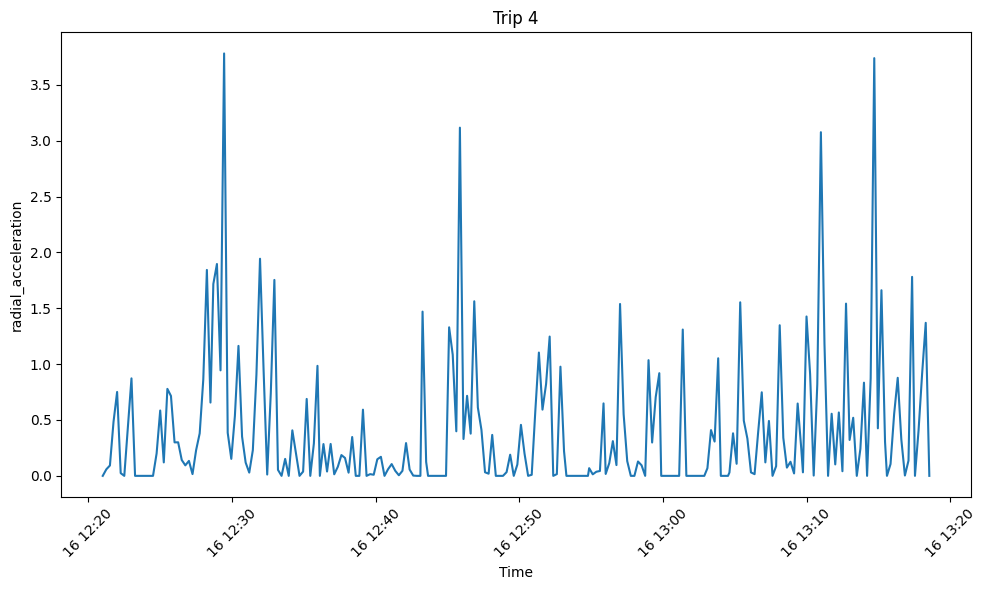

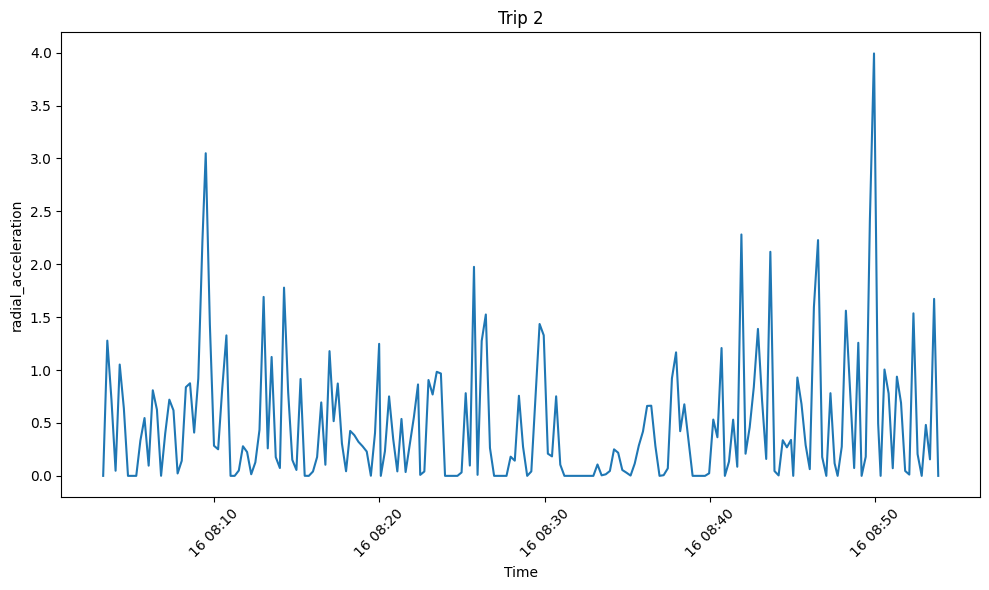

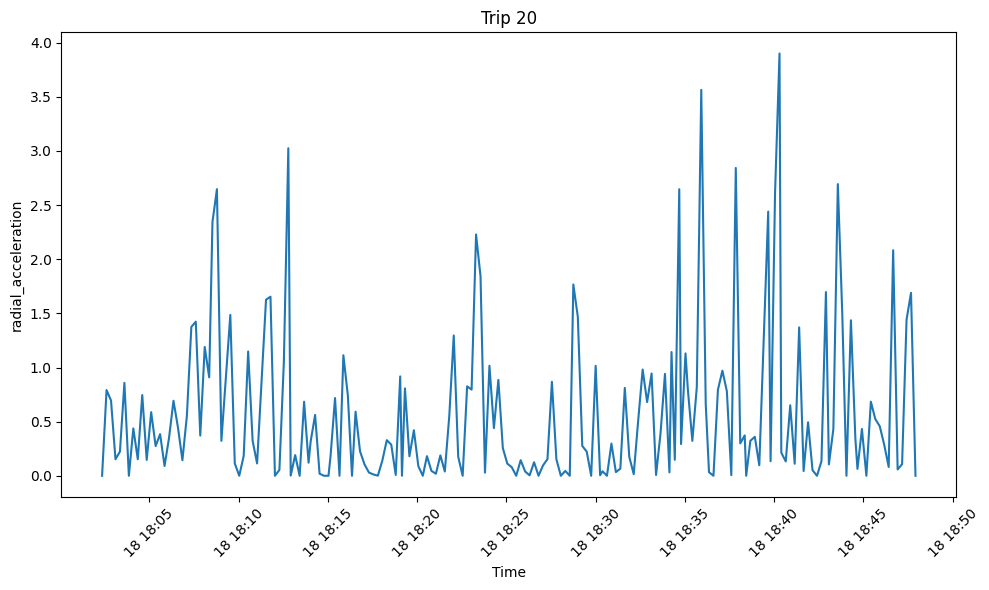

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have 'data' DataFrame containing bus data

# Convert 'devicetime' column to datetime
data['devicetime'] = pd.to_datetime(data['devicetime'])

# Draw a line graph of radial acceleration against time for a single trip
def draw_radial_acceleration_graph(trip_id):
    trip_df = data[data["trip_id"] == trip_id]
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(trip_df["devicetime"], trip_df["radial_acceleration"])
    plt.xlabel("Time")
    plt.ylabel("radial_acceleration")
    plt.title("Trip " + str(trip_id))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout for better formatting
    plt.show()

draw_radial_acceleration_graph(4)
draw_radial_acceleration_graph(2)
draw_radial_acceleration_graph(20)


### Distance from start

#### Cumalative addition of distance

In [26]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'data' with columns: 'trip_id', 'latitude', 'longitude', and 'devicetime'
# Convert the 'devicetime' column to pandas Timestamp if it's not already
data['devicetime'] = pd.to_datetime(data['devicetime'])

# Function to calculate Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth's radius in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    meters = R * c
    return meters

# Calculate the distance between consecutive rows within the same trip
data['distance'] = data.groupby('trip_id').apply(lambda group: haversine_distance(group['latitude'], group['longitude'], group['latitude'].shift(), group['longitude'].shift())).reset_index(level=0, drop=True)

# Calculate cumulative distance for each trip
data['cumulative_distance'] = data.groupby('trip_id')['distance'].cumsum()

print(data)


                id  deviceid          devicetime  latitude  longitude  \
1        574733099       116 2021-10-16 08:03:19  7.293068  80.636430   
2        574733100       116 2021-10-16 08:03:34  7.293043  80.637552   
3        574733101       116 2021-10-16 08:03:49  7.292725  80.637707   
4        574733102       116 2021-10-16 08:04:04  7.292292  80.637663   
5        574736662       116 2021-10-16 08:04:19  7.291640  80.637455   
...            ...       ...                 ...       ...        ...   
4114004  898915939      1719 2022-02-25 16:47:53  7.291572  80.635452   
4114005  898916182      1719 2022-02-25 16:47:57  7.291587  80.635355   
4114006  898917152      1719 2022-02-25 16:48:02  7.291597  80.635293   
4114007  898917150      1719 2022-02-25 16:48:03  7.291605  80.635280   
4114008  898917340      1719 2022-02-25 16:48:05  7.291622  80.635255   

            speed        date      time  \
1        14.03890  2021-10-16  08:03:19   
2        10.25920  2021-10-16  08:03:

In [27]:
# drop distance column and rename cumulative_distance to distance from start
data.drop(['distance'], axis=1, inplace=True)
data.rename(columns={'cumulative_distance': 'distance_from_start'}, inplace=True)


In [28]:
# fill nan with 0
data['distance_from_start'].fillna(0, inplace=True)

In [29]:
# save as csv file 
data.to_csv('../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance.csv', index=False)

In [30]:
# read csv
data = pd.read_csv('../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance.csv')

## Get Accelaration and Breaks

In [32]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'data' with columns: 'acceleration', 'devicetime', and 'trip_id'
# Convert the 'devicetime' column to pandas Timestamp if it's not already
data['devicetime'] = pd.to_datetime(data['devicetime'])

# Calculate time difference between consecutive rows within the same trip
data['time_diff'] = data.groupby('trip_id')['devicetime'].diff()

# Calculate change in acceleration between consecutive rows within the same trip
data['acc_diff'] = data.groupby('trip_id')['acceleration'].diff()

# Filter out rows with time differences close to zero
# data = data[data['time_diff'].dt.total_seconds() > 0.001]  # Adjust the threshold as needed

# Calculate acceleration by dividing acceleration difference by time difference (avoiding division by zero)
data['acceleration_der'] = data['acc_diff'] / data['time_diff'].dt.total_seconds()

# Handle the case where time difference is zero or very close to zero, set acceleration_der to 0
data['acceleration_der'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['acceleration_der'].fillna(0, inplace=True)

data


,id,deviceid,devicetime,latitude,longitude,speed,date,time,geometry,bus_stop,trip_id,direction,count,acceleration,radial_acceleration,distance_from_start,time_diff,acc_diff,acceleration_der
0,574733099,116,2021-10-16 08:03:19,7.293068,80.636430,14.03890,2021-10-16,08:03:19,POINT (184841.00784031872 232320.15459256113),NaN,2.0,1,207,0.323975,0.000000,0.000000,NaT,NaN,0.000000
1,574733100,116,2021-10-16 08:03:34,7.293043,80.637552,10.25920,2021-10-16,08:03:34,POINT (184964.84865244984 232317.35306792473),NaN,2.0,1,207,-0.251980,1.278067,123.738485,0 days 00:00:15,-0.575955,-0.038397
2,574733101,116,2021-10-16 08:03:49,7.292725,80.637707,7.55940,2021-10-16,08:03:49,POINT (184981.95255171193 232282.14959255166),NaN,2.0,1,207,-0.179987,0.722300,163.044397,0 days 00:00:15,0.071993,0.004800
3,574733102,116,2021-10-16 08:04:04,7.292292,80.637663,3.77970,2021-10-16,08:04:04,POINT (184977.15733984314 232234.22458233108),NaN,2.0,1,207,-0.251980,0.048332,211.472339,0 days 00:00:15,-0.071993,-0.004800
4,574736662,116,2021-10-16 08:04:19,7.291640,80.637455,9.17927,2021-10-16,08:04:19,POINT (184954.1363920236 232162.16484193364),101,2.0,1,207,0.359971,1.052222,287.492821,0 days 00:00:15,0.611951,0.040797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034419,898915939,1719,2022-02-25 16:47:53,7.291572,80.635452,2.15983,2022-02-25,16:47:53,POINT (184732.927692229 232154.67833579454),NaN,15890.0,2,1561,0.215983,0.714925,16242.694984,0 days 00:00:10,2.105833,0.210583
4034420,898916182,1719,2022-02-25 16:47:57,7.291587,80.635355,2.15983,2022-02-25,16:47:57,POINT (184722.26205350138 232156.3402929157),NaN,15890.0,2,1561,0.000000,0.003500,16253.479312,0 days 00:00:04,-0.215983,-0.053996
4034421,898917152,1719,2022-02-25 16:48:02,7.291597,80.635293,3.77970,2022-02-25,16:48:02,POINT (184715.44974995626 232157.44817551947),NaN,15890.0,2,1561,0.323974,1.320196,16260.374802,0 days 00:00:05,0.323974,0.064795
4034422,898917150,1719,2022-02-25 16:48:03,7.291605,80.635280,3.77970,2022-02-25,16:48:03,POINT (184713.9815042613 232158.37751184579),NaN,15890.0,2,1561,0.000000,0.128080,16262.113859,0 days 00:00:01,-0.323974,-0.323974


In [33]:
# save as csv file 
data.to_csv('../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance_and_accDiff.csv', index=False)

In [36]:
# Draw a line graph of radial acceleration against time for a single trip
def drawAgainst(data,trip_id,columnx,columny):
    trip_df = data[data["trip_id"] == trip_id]
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(trip_df[f"{columnx}"], trip_df[f"{columny}"])
    plt.xlabel(f"{columnx}")
    plt.ylabel(f"{columny}")
    plt.title("Trip " + str(trip_id))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout for better formatting
    plt.show()


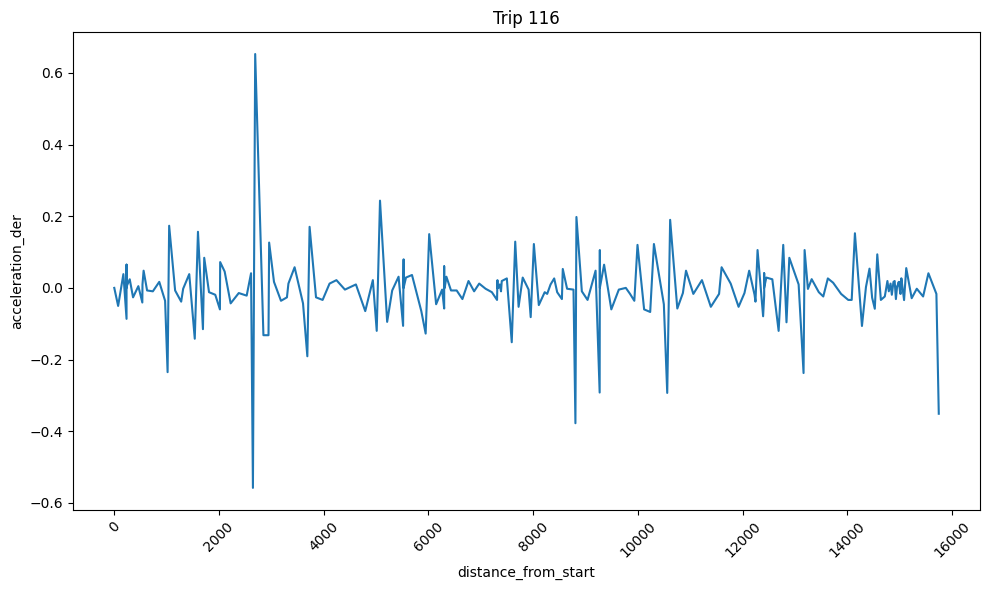

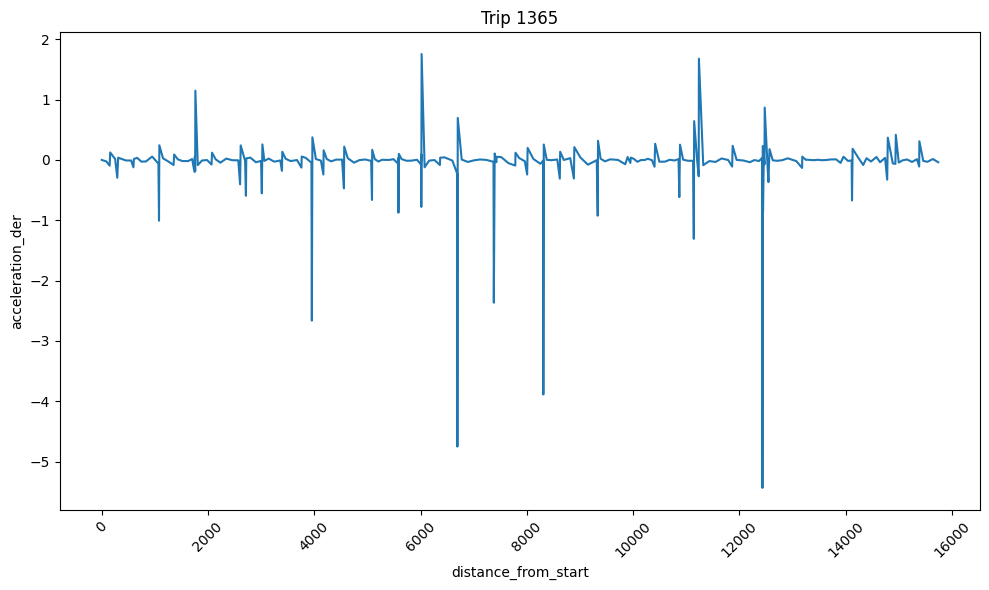

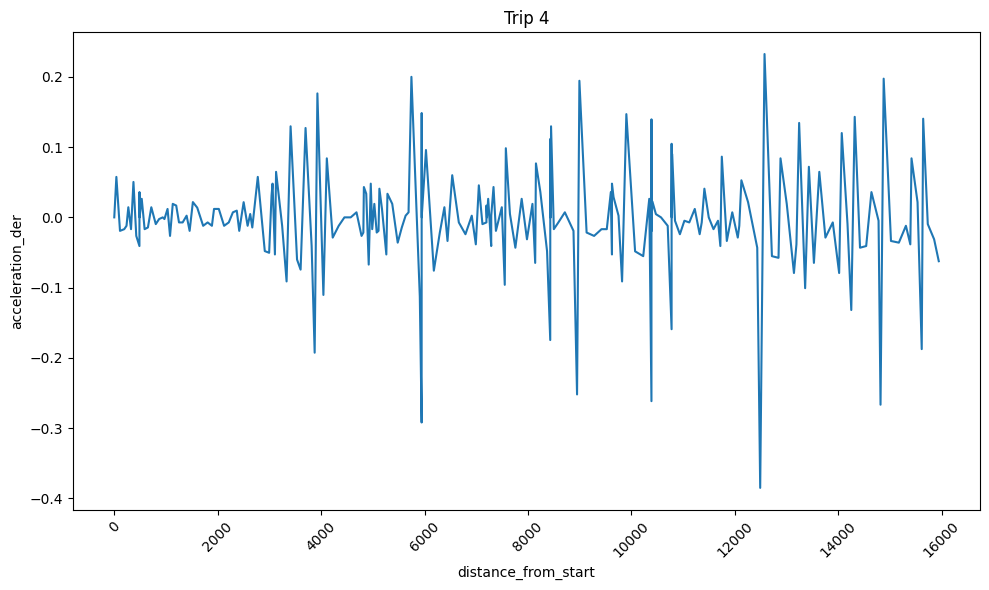

In [38]:
drawAgainst(data,116,'distance_from_start','acceleration_der')
drawAgainst(data,1365,'distance_from_start','acceleration_der')
drawAgainst(data,4,'distance_from_start','acceleration_der')

## Check whether the time or distance is better for TS clusterring

In [39]:
# data with trip id 5672 
data[data['trip_id'] == 5672]

,id,deviceid,devicetime,latitude,longitude,speed,date,time,geometry,bus_stop,trip_id,direction,count,acceleration,radial_acceleration,distance_from_start,time_diff,acc_diff,acceleration_der


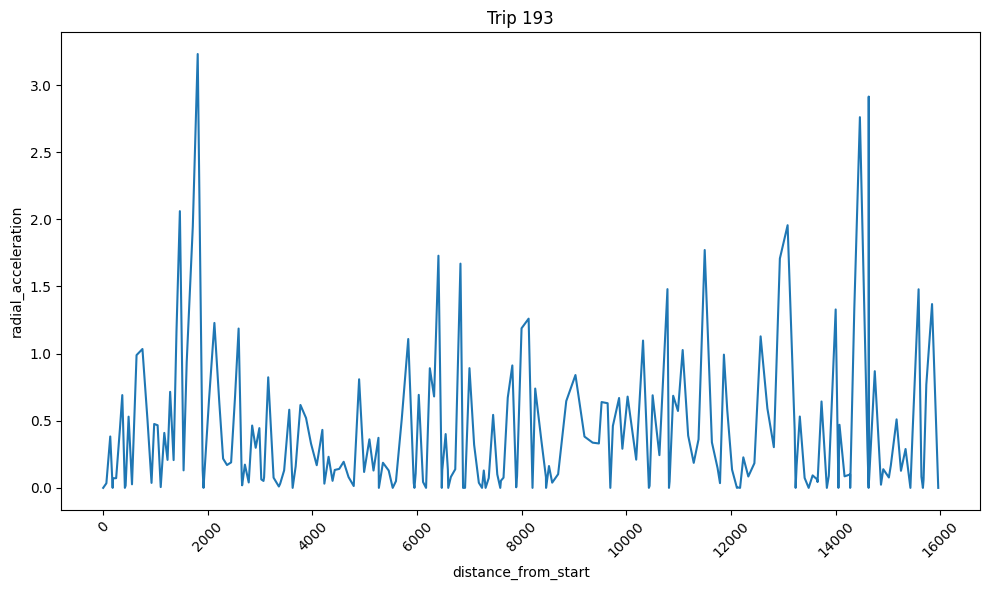

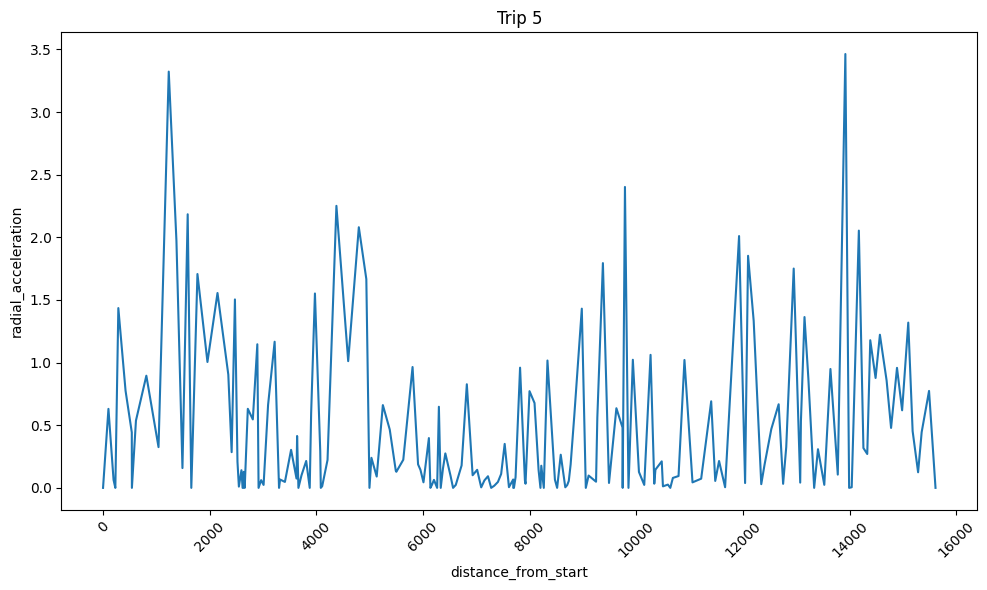

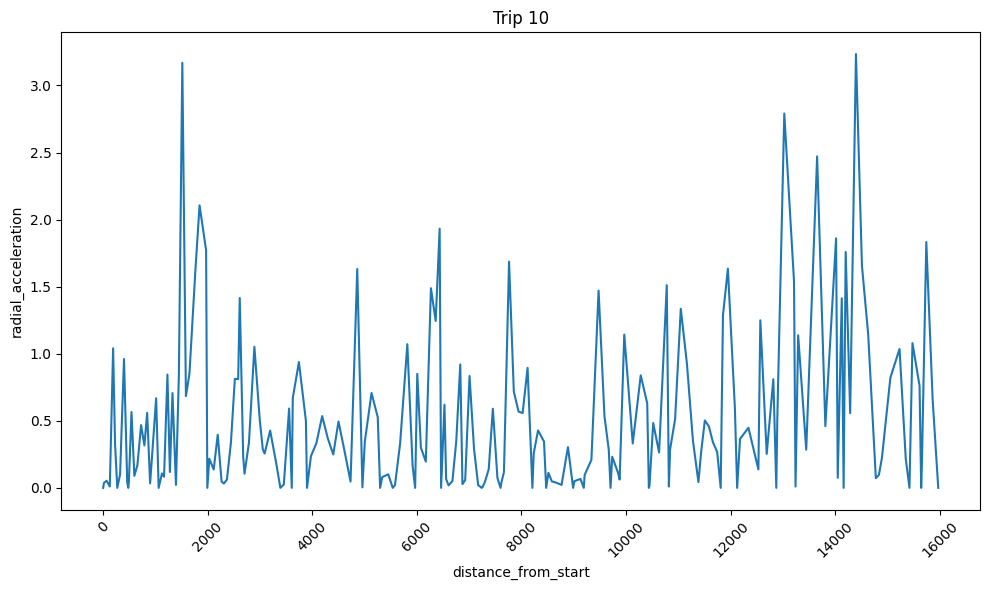

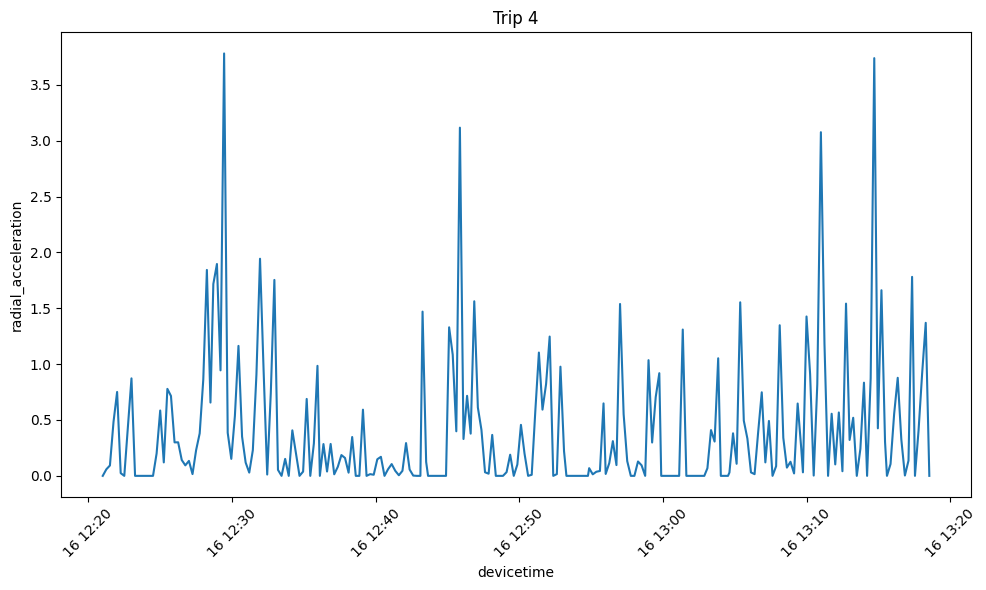

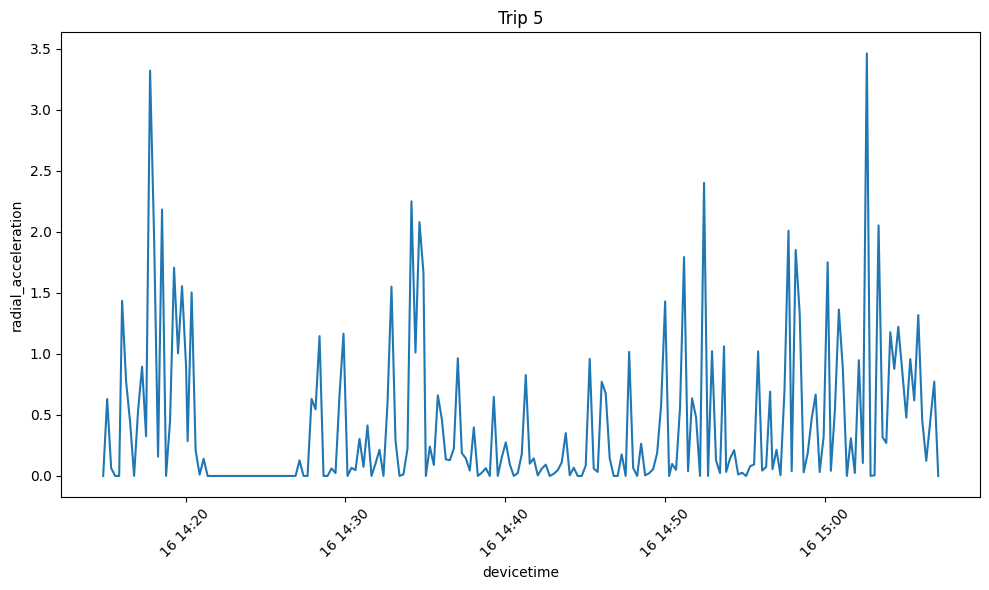

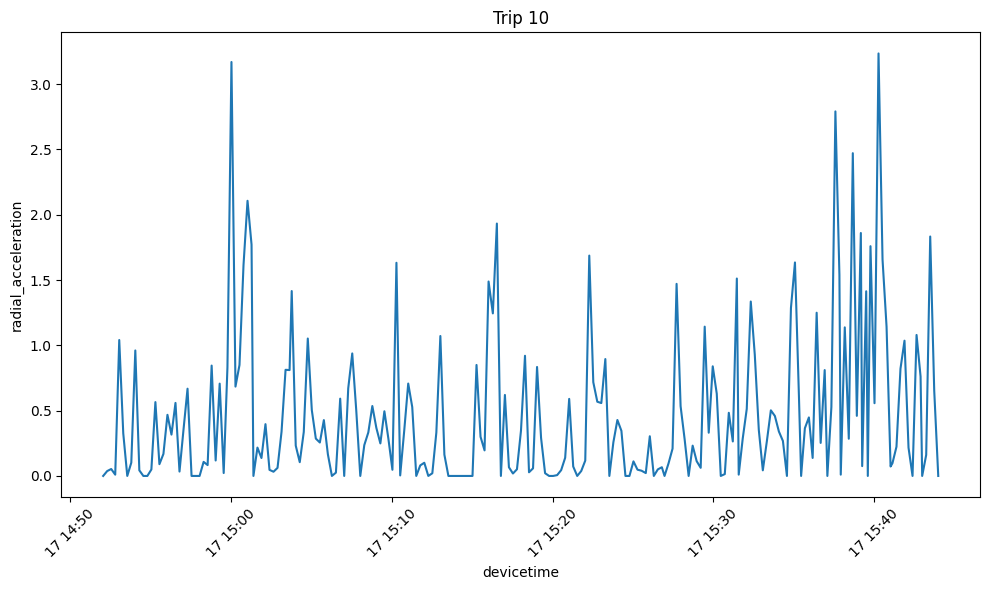

In [40]:
drawAgainst(data,193,'distance_from_start','radial_acceleration')
drawAgainst(data,5,'distance_from_start','radial_acceleration')
drawAgainst(data,10,'distance_from_start','radial_acceleration')

print("=========================================================")

drawAgainst(data,4,'devicetime','radial_acceleration')
drawAgainst(data,5,'devicetime','radial_acceleration')
drawAgainst(data,10,'devicetime','radial_acceleration')

Seem like distance is better